In [3]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 

In [4]:
wandb.login(key = my_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adityapeketii (adityapeketii-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import wandb
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [6]:
class ColorCentroidsDataset(Dataset):
    def __init__(self, cifar_dataset, color_centroids):
        self.cifar_dataset = cifar_dataset
        self.color_centroids = color_centroids
        self.nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
        self.nn_model.fit(color_centroids)
        
    def __len__(self):
        return len(self.cifar_dataset)
    
    def __getitem__(self, idx):
        img, _ = self.cifar_dataset[idx]
        
        img_np = img.permute(1, 2, 0).numpy()
        gray = img_np.mean(axis=2, keepdims=True)
        
        rgb_pixels = img_np.reshape(-1, 3)
        _, indices = self.nn_model.kneighbors(rgb_pixels)
        labels = indices.flatten().reshape(32, 32)
        
        gray_tensor = torch.from_numpy(gray).permute(2, 0, 1).float()
        labels_tensor = torch.from_numpy(labels).long()
        img_color = torch.from_numpy(img_np).permute(2, 0, 1).float()
        
        return gray_tensor, labels_tensor, img_color

In [7]:
class ColorizationCNN(nn.Module):
    def __init__(self, NIC=1, NF=16, NC=24, kernel_size=3):
        super(ColorizationCNN, self).__init__()
        
        padding = kernel_size // 2
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(NIC, NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(NF),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(NF, 2*NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(2*NF),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(2*NF, 4*NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(4*NF),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(4*NF, 2*NF, kernel_size=2, stride=2),
            nn.BatchNorm2d(2*NF),
            nn.ReLU()
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(2*NF, NF, kernel_size=2, stride=2),
            nn.BatchNorm2d(NF),
            nn.ReLU()
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(NF, NC, kernel_size=2, stride=2),
            nn.BatchNorm2d(NC),
            nn.ReLU()
        )
        
        self.classifier = nn.Conv2d(NC, NC, kernel_size=1)
        
    def forward(self, x):
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.classifier(x)
        return x

In [8]:
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, device):
    model.to(device)
    
    pbar = tqdm(range(epochs), desc='Training')
    best_val_loss = float('inf')
    
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for gray, labels, _ in train_loader:
            gray, labels = gray.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(gray)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.numel()
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for gray, labels, _ in val_loader:
                gray, labels = gray.to(device), labels.to(device)
                outputs = model(gray)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        pbar.set_postfix({
            'val_loss': f'{val_loss:.4f}',
            'val_acc': f'{val_acc:.2f}%'
        })
        
        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc
        })
    
    return model, best_val_loss

In [9]:
def visualize_results(model, dataset, color_centroids, device, num_samples=7, log_to_wandb=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import wandb

    model.eval()
    
    fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))
    
    for i in range(num_samples):
        gray, labels, original = dataset[i]
        
        with torch.no_grad():
            gray_input = gray.unsqueeze(0).to(device)
            outputs = model(gray_input)
            pred_labels = outputs.argmax(dim=1).squeeze().cpu().numpy()
        
        # Map predicted labels to colors
        pred_colored = np.zeros((32, 32, 3))
        for h in range(32):
            for w in range(32):
                pred_colored[h, w] = color_centroids[pred_labels[h, w]]
        
        # Row 1: Grayscale
        axes[0, i].imshow(gray.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Example {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # Row 2: Predicted color
        axes[1, i].imshow(pred_colored / 255.0)
        axes[1, i].axis('off')
        
        # Row 3: Ground truth
        axes[2, i].imshow(original.permute(1, 2, 0).numpy() / 255.0)
        axes[2, i].axis('off')
    
    # Add row labels on the left
    axes[0,0].set_ylabel('Grayscale', fontsize=12)
    axes[1,0].set_ylabel('Predicted', fontsize=12)
    axes[2,0].set_ylabel('Ground Truth', fontsize=12)
    
    plt.tight_layout()
    
    if log_to_wandb:
        wandb.log({"colorization_examples": wandb.Image(fig)})
    
    plt.close(fig)
    return fig


Training: 100%|██████████| 25/25 [19:42<00:00, 47.31s/it, val_loss=1.6861, val_acc=39.18%]


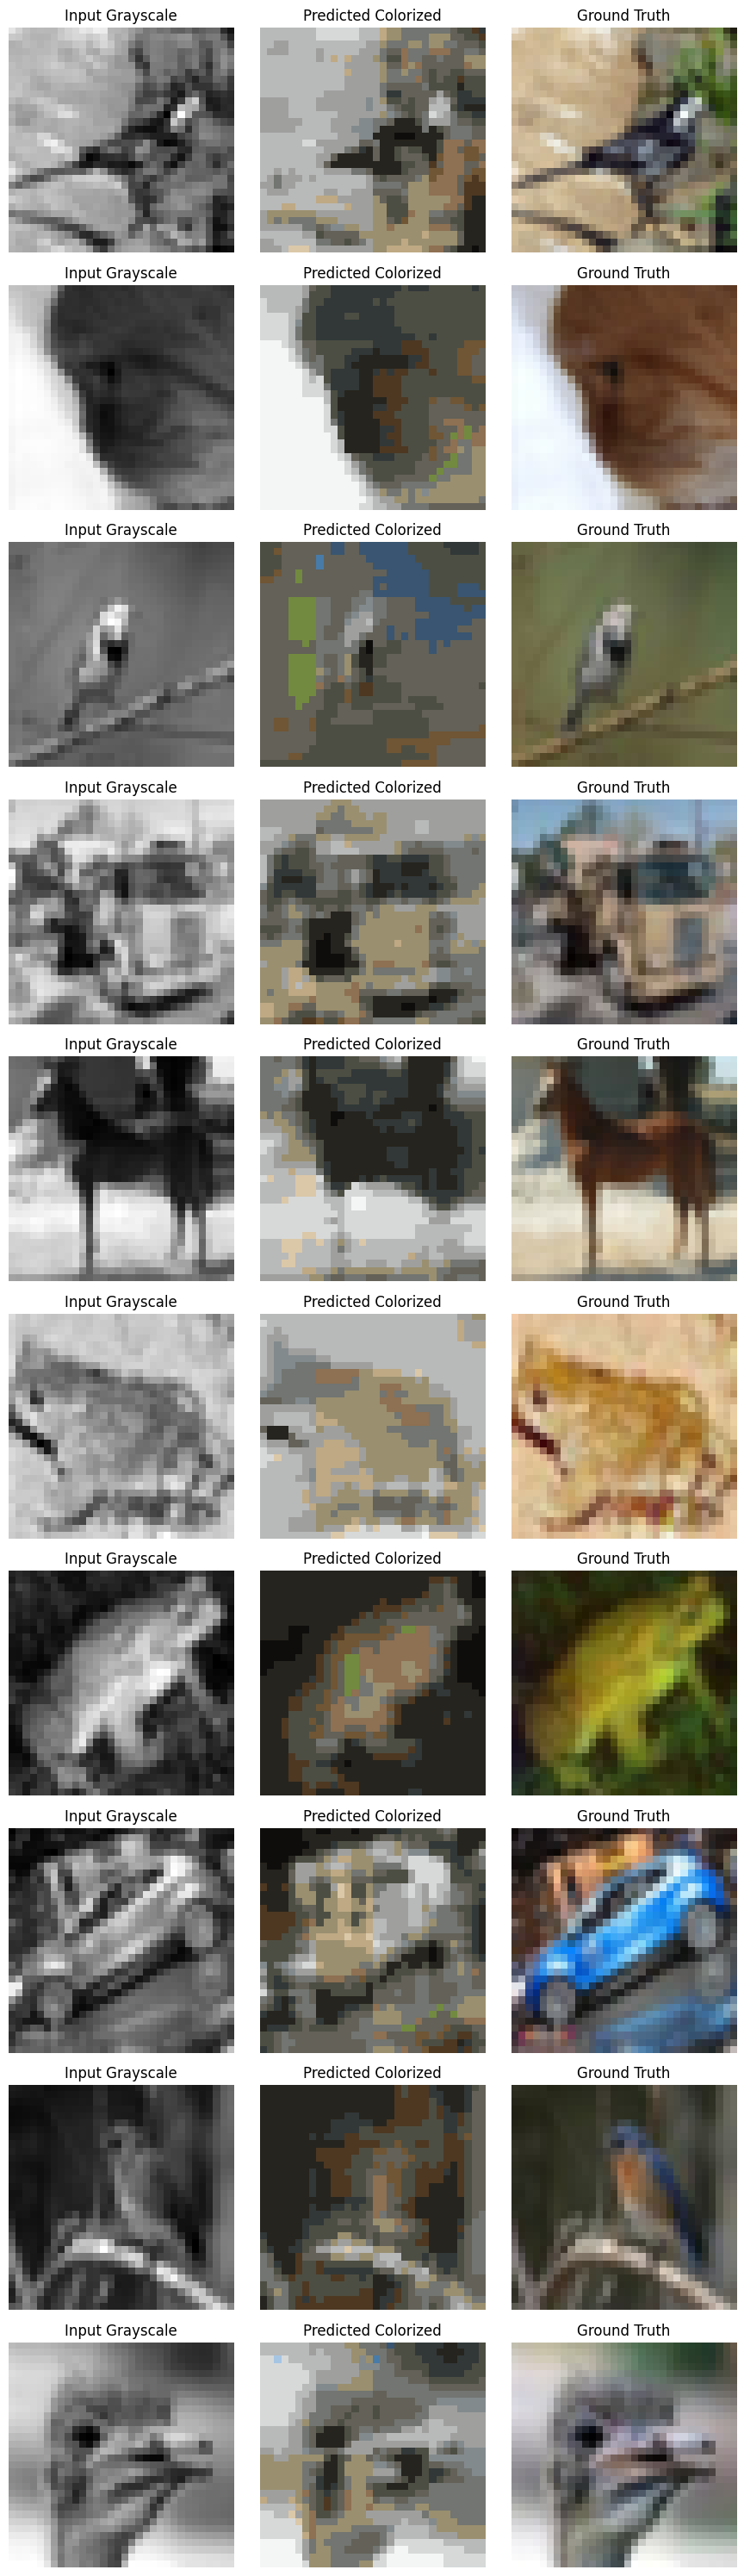

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇▆▇▇▆▆▆▆▆▇▇████▆▇▇
val_loss,█▅▄▄▄▃▃▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▂▂▁
epoch,24
train_accuracy,38.44574
train_loss,1.70891
val_accuracy,39.18383
val_loss,1.68613


In [ ]:
# color_centroids_path = '/kaggle/input/color-centroids/color_centroids.npy'
# color_centroids = np.load(color_centroids_path)

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x * 255)
# ])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# train_size = int(0.9 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# train_color_dataset = ColorCentroidsDataset(train_subset, color_centroids)
# val_color_dataset = ColorCentroidsDataset(val_subset, color_centroids)

# config = {
#     'learning_rate': 1e-3,
#     'batch_size': 64,
#     'NF': 16,
#     'kernel_size': 3,
#     'optimizer': 'Adam',
#     'epochs': 25
# }

# wandb.init(project='image-colorization', config=config, name = 'Test_2', reinit=True, resume= False)

# train_loader = DataLoader(train_color_dataset, batch_size=config['batch_size'], shuffle=True)
# val_loader = DataLoader(val_color_dataset, batch_size=config['batch_size'], shuffle=False)

# model = ColorizationCNN(NIC=1, NF=config['NF'], NC=24)
# criterion = nn.CrossEntropyLoss()

# if config['optimizer'] == 'Adam':
#     optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
# else:
#     optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = train_model(model, train_loader, val_loader, config['epochs'], optimizer, criterion, device)

# visualize_results(model, val_color_dataset, color_centroids, device)

# wandb.finish()


Training: 100%|██████████| 50/50 [40:43<00:00, 48.87s/it, val_loss=1.5131, val_acc=44.08%]


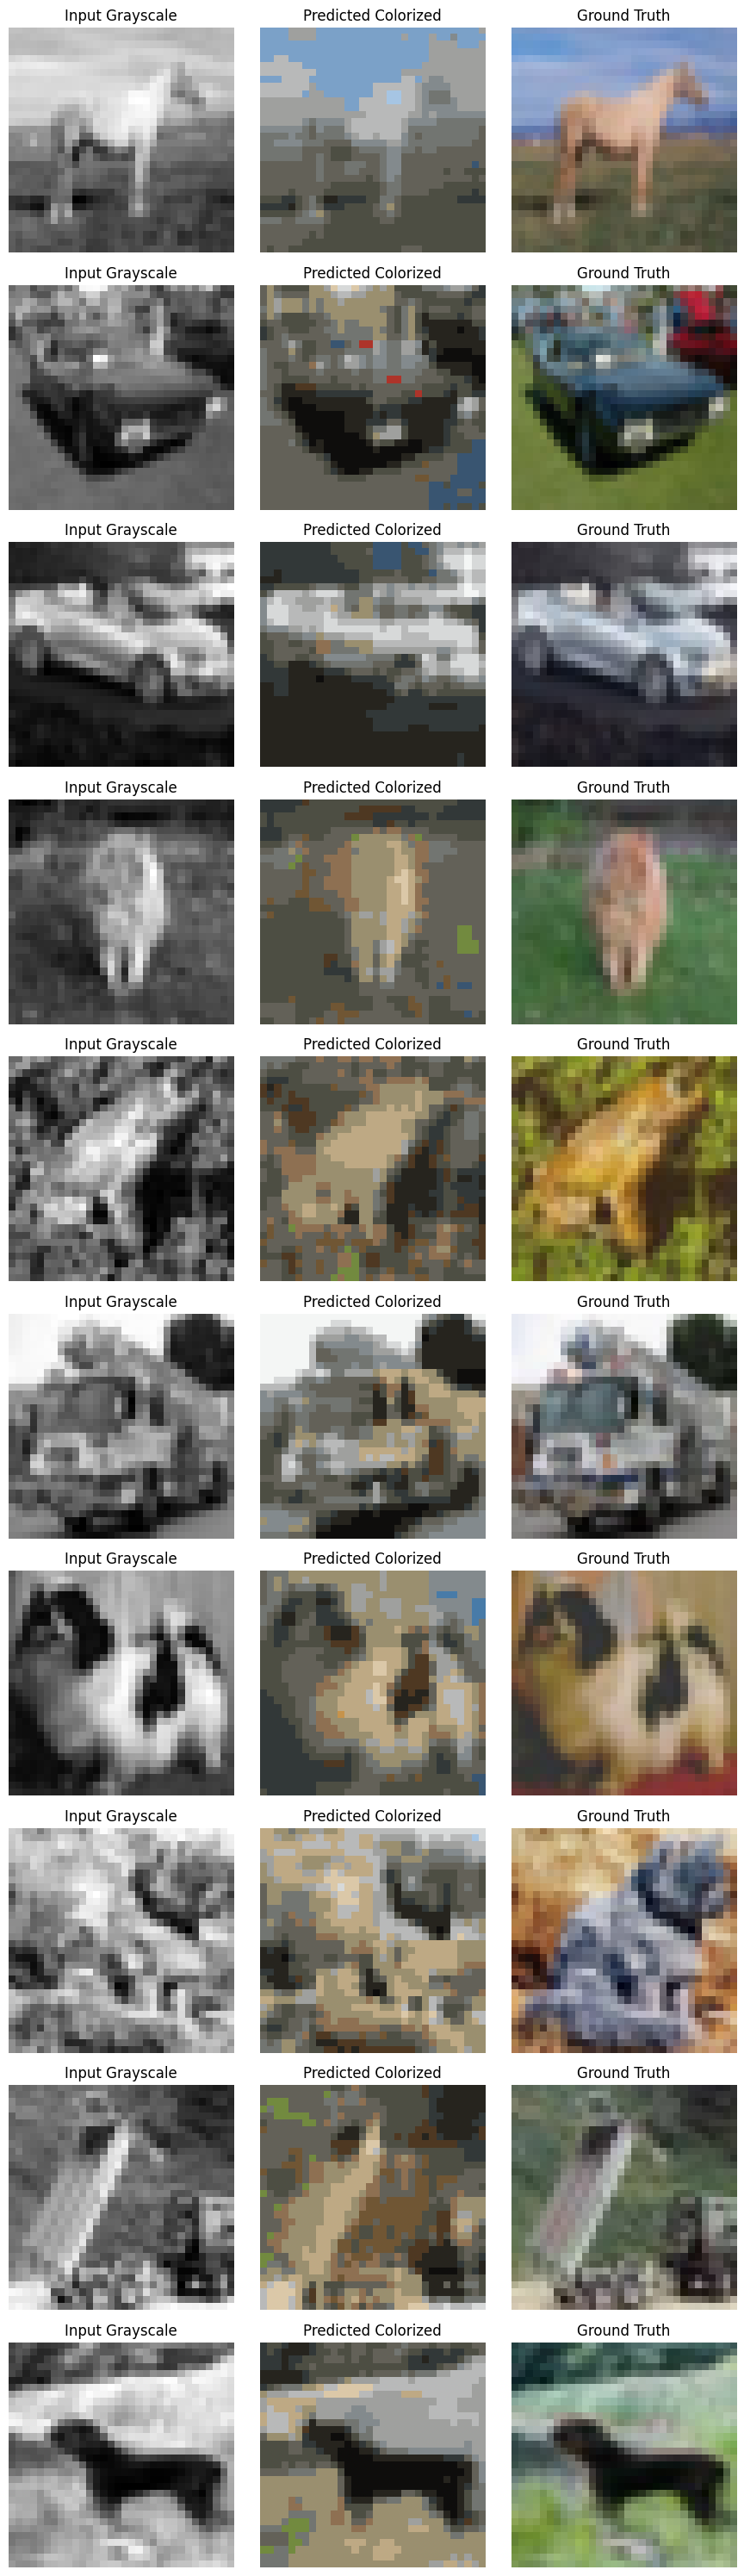

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▆▇▅▇▇▇▇▇▆█▇▇▇█▇█████▇███
val_loss,█▅▄▄▄▄▃▃▃▃▂▂▂▂▂▃▂▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▂▁▁▁
epoch,49
train_accuracy,43.65706
train_loss,1.52213
val_accuracy,44.0816
val_loss,1.51312


In [19]:
# color_centroids_path = '/kaggle/input/color-centroids/color_centroids.npy'
# color_centroids = np.load(color_centroids_path)

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x * 255)
# ])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# train_size = int(0.9 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# train_color_dataset = ColorCentroidsDataset(train_subset, color_centroids)
# val_color_dataset = ColorCentroidsDataset(val_subset, color_centroids)

# config = {
#     'learning_rate': 0.0007,
#     'batch_size': 64,
#     'NF': 32,
#     'kernel_size': 3,
#     'optimizer': 'Adam',
#     'epochs': 50
# }

# wandb.init(project='image-colorization', config=config, name = 'Test_3', reinit=True, resume= False)

# train_loader = DataLoader(train_color_dataset, batch_size=config['batch_size'], shuffle=True)
# val_loader = DataLoader(val_color_dataset, batch_size=config['batch_size'], shuffle=False)

# model = ColorizationCNN(NIC=1, NF=config['NF'], NC=24)
# criterion = nn.CrossEntropyLoss()

# if config['optimizer'] == 'Adam':
#     optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
# else:
#     optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = train_model(model, train_loader, val_loader, config['epochs'], optimizer, criterion, device)

# visualize_results(model, val_color_dataset, color_centroids, device)

# wandb.finish()


In [10]:
color_centroids_path = '/kaggle/input/colour-centroids/color_centroids.npy'
color_centroids = np.load(color_centroids_path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_color_dataset = ColorCentroidsDataset(train_subset, color_centroids)
val_color_dataset = ColorCentroidsDataset(val_subset, color_centroids)

configs = [
    # Adam Optimizer
    {'learning_rate': 1e-4, 'batch_size': 32,  'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'},
    {'learning_rate': 1e-4, 'batch_size': 64,  'NF': 8,  'kernel_size': 5, 'optimizer': 'Adam'},
    {'learning_rate': 1e-4, 'batch_size': 128, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 1e-4, 'batch_size': 64,  'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'},

    {'learning_rate': 3e-4, 'batch_size': 32,  'NF': 8,  'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 3e-4, 'batch_size': 64,  'NF': 8,  'kernel_size': 5, 'optimizer': 'Adam'},
    {'learning_rate': 3e-4, 'batch_size': 128, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 3e-4, 'batch_size': 64,  'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'},

    {'learning_rate': 1e-3, 'batch_size': 32,  'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 32,  'NF': 32, 'kernel_size': 5, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 64,  'NF': 8,  'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 64,  'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 64,  'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 64,  'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'},
    {'learning_rate': 1e-3, 'batch_size': 128, 'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'},

    {'learning_rate': 3e-3, 'batch_size': 64,  'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'},

    # SGD Optimizer
    {'learning_rate': 1e-4, 'batch_size': 128, 'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD'},
    {'learning_rate': 3e-4, 'batch_size': 32,  'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD'},
    {'learning_rate': 3e-4, 'batch_size': 64,  'NF': 8,  'kernel_size': 5, 'optimizer': 'SGD'},
    {'learning_rate': 3e-3, 'batch_size': 32,  'NF': 16, 'kernel_size': 5, 'optimizer': 'SGD'},
    {'learning_rate': 3e-3, 'batch_size': 128, 'NF': 8,  'kernel_size': 3, 'optimizer': 'SGD'},
]



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_val_loss = float('inf')
best_config = None
best_model = None

for run_idx, config in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Run {run_idx + 1}/{len(configs)}")
    print(f"Config: {config}")
    print(f"{'='*60}\n")
    
    config['epochs'] = 30
    
    run = wandb.init(project='SMAI-A4-image-colorization', name=f'config{run_idx + 1}', config=config, reinit=True)
    
    train_loader = DataLoader(train_color_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_color_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
    
    model = ColorizationCNN(NIC=1, NF=config['NF'], NC=24, kernel_size=config['kernel_size'])
    criterion = nn.CrossEntropyLoss()
    
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    
    model, run_best_val_loss = train_model(model, train_loader, val_loader, config['epochs'], optimizer, criterion, device)
    
    checkpoint_path = f'checkpoint_config{run_idx + 1}.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'val_loss': run_best_val_loss
    }, checkpoint_path)
    
    wandb.save(checkpoint_path)
    
    visualize_results(model, val_color_dataset, color_centroids, device, num_samples=10, log_to_wandb=True)
    
    wandb.log({
        'best_val_loss': run_best_val_loss
    })
    
    wandb.summary['best_val_loss'] = run_best_val_loss
    wandb.summary['checkpoint_path'] = checkpoint_path
    
    if run_best_val_loss < best_val_loss:
        best_val_loss = run_best_val_loss
        best_config = config
        best_model = model
        torch.save(model.state_dict(), 'best_model_overall.pth')
    
    wandb.finish()

print(f"\n{'='*60}")
print(f"Best configuration:")
print(f"Config: {best_config}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"{'='*60}\n")

wandb.init(project='SMAI-A4-image-colorization', name='best_model_final_visualization', config=best_config)
visualize_results(best_model, val_color_dataset, color_centroids, device, num_samples=10, log_to_wandb=True)
wandb.finish()

100%|██████████| 170M/170M [00:04<00:00, 39.6MB/s] 



Run 1/21
Config: {'learning_rate': 0.0001, 'batch_size': 32, 'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'}



wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Training: 100%|██████████| 30/30 [13:50<00:00, 27.69s/it, val_loss=1.5157, val_acc=44.36%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███▇█▇█▇█████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁
best_val_loss,1.51572
checkpoint_path,checkpoint_config1.p...
epoch,29
train_accuracy,41.56597
train_loss,1.58852



Run 2/21
Config: {'learning_rate': 0.0001, 'batch_size': 64, 'NF': 8, 'kernel_size': 5, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:36<00:00, 25.21s/it, val_loss=1.7391, val_acc=38.15%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.73913
checkpoint_path,checkpoint_config2.p...
epoch,29
train_accuracy,36.57403
train_loss,1.77443



Run 3/21
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:02<00:00, 24.08s/it, val_loss=1.7876, val_acc=37.28%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.78756
checkpoint_path,checkpoint_config3.p...
epoch,29
train_accuracy,36.36674
train_loss,1.80723



Run 4/21
Config: {'learning_rate': 0.0001, 'batch_size': 64, 'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:52<00:00, 25.76s/it, val_loss=1.6165, val_acc=41.66%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.61652
checkpoint_path,checkpoint_config4.p...
epoch,29
train_accuracy,40.1401
train_loss,1.65252



Run 5/21
Config: {'learning_rate': 0.0003, 'batch_size': 32, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [14:08<00:00, 28.28s/it, val_loss=1.8619, val_acc=35.32%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▆▆▅▅▆▇▆▆▆▇▅▇▇▇▆██▆█▇▆▅██
val_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▁
best_val_loss,1.86194
checkpoint_path,checkpoint_config5.p...
epoch,29
train_accuracy,33.11104
train_loss,1.92029



Run 6/21
Config: {'learning_rate': 0.0003, 'batch_size': 64, 'NF': 8, 'kernel_size': 5, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:38<00:00, 25.30s/it, val_loss=1.6708, val_acc=39.39%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇███▇█▇▇███
val_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁
best_val_loss,1.65711
checkpoint_path,checkpoint_config6.p...
epoch,29
train_accuracy,38.69663
train_loss,1.6933



Run 7/21
Config: {'learning_rate': 0.0003, 'batch_size': 128, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:06<00:00, 24.20s/it, val_loss=1.7254, val_acc=38.52%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.71564
checkpoint_path,checkpoint_config7.p...
epoch,29
train_accuracy,37.95803
train_loss,1.73827



Run 8/21
Config: {'learning_rate': 0.0003, 'batch_size': 64, 'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:33<00:00, 25.12s/it, val_loss=1.5742, val_acc=42.44%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▆▇▇▆▇▇▇██▇▇███████▇
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
best_val_loss,1.5539
checkpoint_path,checkpoint_config8.p...
epoch,29
train_accuracy,41.74409
train_loss,1.58978



Run 9/21
Config: {'learning_rate': 0.001, 'batch_size': 32, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [13:53<00:00, 27.78s/it, val_loss=1.6855, val_acc=39.72%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▆▅▆▇▇▄▇▆▅▇▇▅▆▆▇█▇▇█▇███▇███
val_loss,██▄▄▄▄▃▃▆▂▃▄▂▂▄▃▃▂▁▂▂▁▁▁▁▁▁▁▁▁
best_val_loss,1.67518
checkpoint_path,checkpoint_config9.p...
epoch,29
train_accuracy,38.28097
train_loss,1.7148



Run 10/21
Config: {'learning_rate': 0.001, 'batch_size': 32, 'NF': 32, 'kernel_size': 5, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [13:58<00:00, 27.94s/it, val_loss=1.3077, val_acc=50.11%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▁▃▃▅▆▆▆▆▆▆▆▇▇▇▇▇▅▇▅▇▇▇█▆███
val_loss,█▆▆█▅▆▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▄▂▁▂▁▂▁▁▁
best_val_loss,1.30145
checkpoint_path,checkpoint_config10....
epoch,29
train_accuracy,49.83865
train_loss,1.31253



Run 11/21
Config: {'learning_rate': 0.001, 'batch_size': 64, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:44<00:00, 25.50s/it, val_loss=1.8450, val_acc=35.50%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▇▆▆▅▇▇▇▇█▆▆█▇▇▇▇█▇███▆▇█
val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▁▁
best_val_loss,1.83431
checkpoint_path,checkpoint_config11....
epoch,29
train_accuracy,34.5082
train_loss,1.86565



Run 12/21
Config: {'learning_rate': 0.001, 'batch_size': 64, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:31<00:00, 25.07s/it, val_loss=1.6743, val_acc=39.85%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▅▆▆▆▇▆▆▇▆▇▇█▆▆▇▇▇▆███▇████
val_loss,█▆▄▄▄▃▃▃▂▃▃▂▃▂▂▂▂▂▂▁▂▃▁▁▁▂▁▁▁▁
best_val_loss,1.67425
checkpoint_path,checkpoint_config12....
epoch,29
train_accuracy,38.48907
train_loss,1.7065



Run 13/21
Config: {'learning_rate': 0.001, 'batch_size': 64, 'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:39<00:00, 25.31s/it, val_loss=1.5862, val_acc=41.34%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▅▆▅▆▆▆▇▆▅▇▅▇▇▆▇▇▇▆▇██▆█▇▅
val_loss,█▆▅▄▄▄▃▄▂▂▃▂▃▃▂▃▂▂▂▂▂▂▃▂▁▁▂▁▂▄
best_val_loss,1.44672
checkpoint_path,checkpoint_config13....
epoch,29
train_accuracy,44.85808
train_loss,1.4746



Run 14/21
Config: {'learning_rate': 0.001, 'batch_size': 64, 'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:44<00:00, 25.49s/it, val_loss=1.5318, val_acc=43.54%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▃▄▅▅▆▄▆▅▄▆▆▆▇▇▇▇▇▇▆██▇█▇▇██
val_loss,█▅▄▅▄▄▄▃▄▃▃▄▃▂▂▂▂▂▂▂▁▂▁▁▂▁▂▂▁▁
best_val_loss,1.52699
checkpoint_path,checkpoint_config14....
epoch,29
train_accuracy,42.84107
train_loss,1.54994



Run 15/21
Config: {'learning_rate': 0.001, 'batch_size': 128, 'NF': 16, 'kernel_size': 5, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:16<00:00, 24.55s/it, val_loss=1.4859, val_acc=44.35%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▄▆▆▄▆▅▇▆▆▇▇▇▇▇▇██▇███▇▇███▇
val_loss,█▆▄▄▃▃▄▃▃▂▃▃▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁
best_val_loss,1.459
checkpoint_path,checkpoint_config15....
epoch,29
train_accuracy,45.08018
train_loss,1.46873



Run 16/21
Config: {'learning_rate': 0.003, 'batch_size': 64, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam'}



Training: 100%|██████████| 30/30 [12:47<00:00, 25.58s/it, val_loss=1.6753, val_acc=39.89%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇████████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▅▄▄▅▆▄▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇██▇▆█
val_loss,▇█▆▄▄▄▄▄▃▄▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▂▃▁
best_val_loss,1.66378
checkpoint_path,checkpoint_config16....
epoch,29
train_accuracy,39.2056
train_loss,1.68064



Run 17/21
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD'}



Training: 100%|██████████| 30/30 [12:06<00:00, 24.22s/it, val_loss=2.7519, val_acc=14.62%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▁▂▂▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
train_loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
val_accuracy,▁▁▂▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
val_loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
best_val_loss,2.75192
checkpoint_path,checkpoint_config17....
epoch,29
train_accuracy,14.56363
train_loss,2.75769



Run 18/21
Config: {'learning_rate': 0.0003, 'batch_size': 32, 'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD'}



Training: 100%|██████████| 30/30 [13:46<00:00, 27.55s/it, val_loss=1.8730, val_acc=34.96%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.87305
checkpoint_path,checkpoint_config18....
epoch,29
train_accuracy,33.0887
train_loss,1.92774



Run 19/21
Config: {'learning_rate': 0.0003, 'batch_size': 64, 'NF': 8, 'kernel_size': 5, 'optimizer': 'SGD'}



Training: 100%|██████████| 30/30 [12:43<00:00, 25.45s/it, val_loss=2.1485, val_acc=29.39%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇██████
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
best_val_loss,2.14853
checkpoint_path,checkpoint_config19....
epoch,29
train_accuracy,28.66849
train_loss,2.16746



Run 20/21
Config: {'learning_rate': 0.003, 'batch_size': 32, 'NF': 16, 'kernel_size': 5, 'optimizer': 'SGD'}



Training: 100%|██████████| 30/30 [14:27<00:00, 28.90s/it, val_loss=1.5193, val_acc=43.79%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▆▅▆▆▆▇▇▆▇▇▅▇▇▆▇█▆▇▇▇▆█▅▇▇▇
val_loss,█▆▅▄▃▄▃▂▂▂▂▂▂▂▃▂▁▂▂▁▂▁▂▂▃▁▃▂▂▁
best_val_loss,1.49347
checkpoint_path,checkpoint_config20....
epoch,29
train_accuracy,42.35384
train_loss,1.56056



Run 21/21
Config: {'learning_rate': 0.003, 'batch_size': 128, 'NF': 8, 'kernel_size': 3, 'optimizer': 'SGD'}



Training: 100%|██████████| 30/30 [12:12<00:00, 24.43s/it, val_loss=1.9175, val_acc=34.12%]


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████▇████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.91755
checkpoint_path,checkpoint_config21....
epoch,29
train_accuracy,33.28499
train_loss,1.93739



Best configuration:
Config: {'learning_rate': 0.001, 'batch_size': 32, 'NF': 32, 'kernel_size': 5, 'optimizer': 'Adam', 'epochs': 30}
Best Validation Loss: 1.3015

